# Packing circuits

This notebook looks at some examples of packing circuits to reduce their ancilla costs

First, import the modules we need.

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket_dqc.packing import to_bipartite, minimum_vertex_cover

## Trivial example

The first circuit we'll look at is extremely trivial, we have two global gates which we can pack together with one ebit.

In [2]:
circ0 = Circuit()

server_1 = circ0.add_q_register('Server 1', 1)
server_2 = circ0.add_q_register('Server 2', 1)

circ0.CZ(server_1[0],server_2[0])
circ0.CZ(server_1[0],server_2[0])

render_circuit_jupyter(circ0)

In [3]:
graph0 = to_bipartite(circ0)
mvc0 = minimum_vertex_cover(graph0)
print(f'We can pack this with {len(mvc0)} ebits.')

We can pack this with 1 ebits.


## (Anti) Diagonal local gates

Even if we have local gates inserted between our controls, if the local gate is antidiagonal/diagonal, we can still pack these together.

In [4]:
circ1 = Circuit()

server_1 = circ1.add_q_register('Server 1', 1)
server_2 = circ1.add_q_register('Server 2', 1)

circ1.CZ(server_1[0],server_2[0])
circ1.X(server_1[0])
circ1.CZ(server_1[0],server_2[0])

render_circuit_jupyter(circ1)

X is antidiagonal, so does not affect our bipartite graph.

In [5]:
graph1 = to_bipartite(circ1)
mvc1 = minimum_vertex_cover(graph1)
print(f'We can pack this with {len(mvc1)} ebits.')

We can pack this with 1 ebits.


## Non packable local gates
If the gate is not (anti) diagonal we can no longer pack gates together, so now there are two vertices on `Server 1` side

In [6]:
circ2 = Circuit()

server_1 = circ2.add_q_register('Server 1', 1)
server_2 = circ2.add_q_register('Server 2', 1)

circ2.CZ(server_1[0],server_2[0])
circ2.H(server_1[0])
circ2.CZ(server_1[0],server_2[0])

render_circuit_jupyter(circ2)

In [7]:
graph2 = to_bipartite(circ2)
mvc2 = minimum_vertex_cover(graph2)
print(f'We can pack this with {len(mvc2)} ebits.')

We can pack this with 1 ebits.


We can still just pack this with 1 ebit however, since CZ gates allow either qubit to be control, hence the single vertex on `Server 2` side is sufficient to act as a minimum vertex cover.

We can verify that the vertices are different by looking at the minimum vertex covers explicitly

In [8]:
print(f'The MVC for circ1 is {mvc1}')
print(f'The MVC for circ2 is {mvc2}')

The MVC for circ1 is {0}
The MVC for circ2 is {1}


## More complicated circuits

Let's up the ante a bit now, and look at a circuit across two servers, each with 3 qubits.

In [21]:
circ3 = Circuit()

s1 = circ3.add_q_register('Server 1', 3)
s2 = circ3.add_q_register('Server 2', 3)

circ3.CZ(s1[0], s2[0])
circ3.CZ(s1[1], s2[0])
circ3.CZ(s1[1], s2[1])
circ3.H(s1[1])
circ3.CZ(s1[1], s2[2])
circ3.CZ(s1[2], s2[1])
circ3.CZ(s1[0], s2[0])
circ3.CZ(s1[0], s2[1])
circ3.H(s2[0])
circ3.CZ(s1[0], s2[2])
circ3.X(s1[0])
circ3.CZ(s1[0], s2[0])

render_circuit_jupyter(circ3)

Just by looking at this circuit, it's not immediately obvious what the minimum number of ebits required is.

Luckily `minimum_vertex_cover()` can tell us!

In [10]:
graph3, simultaneous_max3 = to_bipartite(circ3, simultaneous_max = True)
mvc3 = minimum_vertex_cover(graph3)
print(f'We can pack this with {len(mvc3)} ebits.')

We can pack this with 4 ebits.


So this circuit can be implemented with 4 ebits.

## Not all packings are created equal

MVCs are often not unique, as is the case for the bipartite graph of `circ3` shown above.

To see this let's first annotate and label the vertices of the above circuit, as they are labelled by `to_bipartite()`.

<img src="assets/labelled_circuit_no_limits.png" style='width: 80%; margin: auto'/>

This can be represented by the following bipartite graph.

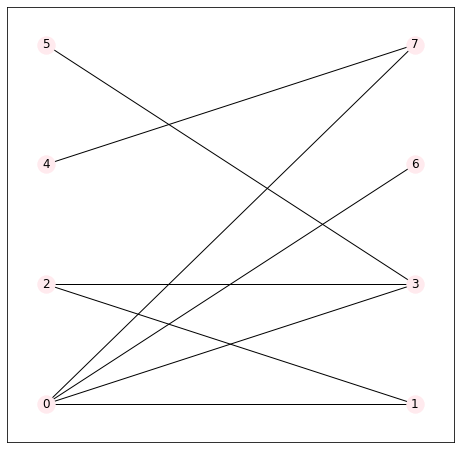

In [11]:
import networkx as nx

nx.draw_networkx(
    graph3.nx_graph,
    pos = nx.drawing.layout.bipartite_layout(graph3.nx_graph, graph3.left_vertices),
    node_color = '#ffeaee',
)

Here is a MVC for this graph

In [12]:
print(mvc3)

{0, 2, 4, 5}


Note that for this MVC, qubit `Server 1[0]` is teleported for the duration of the circuit, and other qubits from `Server 1` are teleported additionally while this occurs, so `Server 2` needs 2 ancilla available for teleportation.

This can be returned also from `to_bipartite()`, if we pass in `simultaneous_packing = True`, which is what we actually did earlier.


In [13]:
print(f'Packing all the vertices on Server 1 requires up to {simultaneous_max3[1]} simultaneous packings.')
print(f'Packing all the vertices on Server 2 requires up to {simultaneous_max3[0]} simultaneous packings.')

Packing all the vertices on Server 1 requires up to 2 simultaneous packings.
Packing all the vertices on Server 2 requires up to 1 simultaneous packings.


However, another MVC could be `{1,3,6,7}` which again uses 4 ebits, but only requires one ancilla to teleport to on `Server 1` at any one time. If we are limited by the number of ancilla available for teleportation then this might be an important consideration.

To take account of this, we can specify how many ancilla are available on either server when we make a call to `to_bipartite()`. This alters how many vertices are added to the bipartite graph.

In [24]:
graph4 = to_bipartite(circ3, (1,1), debugging = True)

serverServer 1 index[0]
Vertex 0
[CZ Server 1[0], Server 2[0];]
Vertex 3
[CZ Server 1[0], Server 2[0];]
Vertex 9
[CZ Server 1[0], Server 2[1];]
Vertex 11
[CZ Server 1[0], Server 2[2];, X Server 1[0];, CZ Server 1[0], Server 2[0];]


serverServer 1 index[1]
Vertex 2
[CZ Server 1[1], Server 2[0];]
Vertex 4
[CZ Server 1[1], Server 2[1];]
Vertex 6
[H Server 1[1];, CZ Server 1[1], Server 2[2];]


serverServer 1 index[2]
Vertex 7
[CZ Server 1[2], Server 2[1];]


serverServer 2 index[0]
Vertex 1
[CZ Server 1[0], Server 2[0];, CZ Server 1[1], Server 2[0];, CZ Server 1[0], Server 2[0];]
Vertex 8
[H Server 2[0];, CZ Server 1[0], Server 2[0];]


serverServer 2 index[1]
Vertex 5
[CZ Server 1[1], Server 2[1];, CZ Server 1[2], Server 2[1];, CZ Server 1[0], Server 2[1];]


serverServer 2 index[2]
Vertex 10
[CZ Server 1[1], Server 2[2];, CZ Server 1[0], Server 2[2];]




<img src="assets/labelled_circuit_with_limits.png" style='width: 80%; margin: auto'/>

Note how many more vertices have been added to `Server 1`, since vertices must be broken up if we try to pack two simultaneously.

We now can find an MVC that only requires one ancilla on either server to execute the circuit.

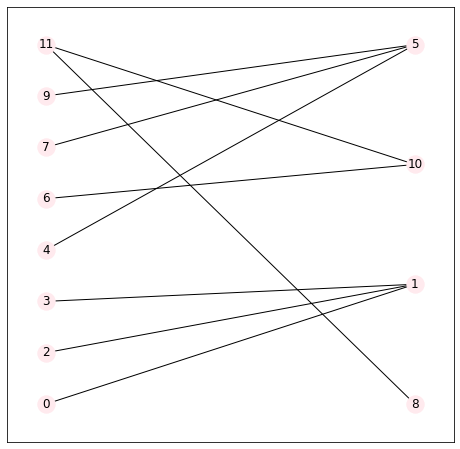

In [15]:
nx.draw_networkx(
    graph4.nx_graph,
    pos = nx.drawing.layout.bipartite_layout(graph4.nx_graph, graph4.left_vertices),
    node_color = '#ffeaee',
)

In [16]:
mvc4 = minimum_vertex_cover(graph4)
print(mvc4)

{1, 11, 5, 6}
